In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
import numpy as np

In [ ]:
df = pd.read_csv('/content/updated_preprocessed_data.csv')

In [ ]:
df.drop(columns=['reviewText', 'summary',], inplace=True)

In [ ]:
print("\nMissing values:")
print(df.isnull().sum())


Missing values:
overall              0
verified             0
text                 0
additional_clean    59
sentiment            0
dtype: int64


In [ ]:
df['additional_clean'].fillna('', inplace=True)

In [ ]:
df = df[df['verified'] == True]

In [ ]:
tokenized_text = df['additional_clean'].apply(lambda x: x.split())

In [ ]:
word2vec_model = Word2Vec(sentences=tokenized_text, vector_size=300, window=5, min_count=5, workers=4)


In [ ]:
def text_to_vector(text):
    vector = np.zeros(word2vec_model.vector_size)
    count = 0
    for word in text.split():
        if word in word2vec_model.wv:
            vector += word2vec_model.wv[word]
            count += 1
    if count != 0:
        vector /= count
    return vector

In [ ]:
word2vec_vectors = df['additional_clean'].apply(text_to_vector)

In [ ]:
word2vec_matrix = np.stack(word2vec_vectors)

In [ ]:
svd = TruncatedSVD(n_components=100)
word2vec_matrix_svd = svd.fit_transform(word2vec_matrix)

In [ ]:

silhouette_scores = []
num_clusters_range = []

In [ ]:
num_clusters_range = range(2, 11)

In [ ]:
for num_clusters in num_clusters_range:

    kmeans = KMeans(n_clusters=num_clusters,n_init=10, random_state=42)


    kmeans.fit(word2vec_matrix_svd)


    cluster_labels = kmeans.labels_


    silhouette_avg = silhouette_score(word2vec_matrix_svd, cluster_labels)
    silhouette_scores.append(silhouette_avg)

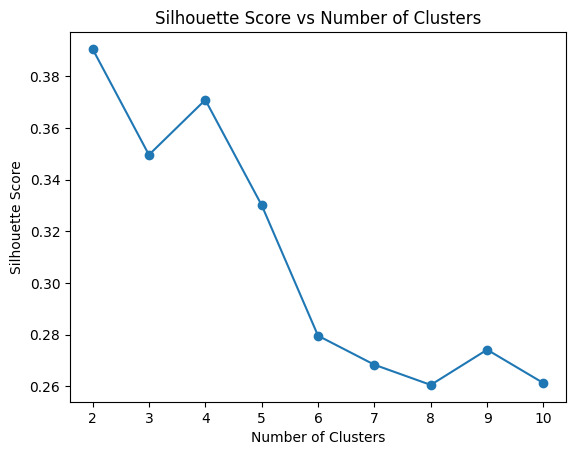

In [ ]:
plt.plot(num_clusters_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.show()

In [ ]:
optimal_num_clusters = num_clusters_range[silhouette_scores.index(max(silhouette_scores))]


In [ ]:
kmeans_optimal = KMeans(n_clusters=optimal_num_clusters,n_init=10, random_state=42)

In [ ]:
kmeans_optimal.fit(word2vec_matrix_svd)

KMeans(n_clusters=2, n_init=10, random_state=42)

In [ ]:
cluster_labels_optimal = kmeans_optimal.labels_

In [ ]:
df['cluster'] = cluster_labels_optimal

In [ ]:
print(df['cluster'].value_counts())

cluster
0    6762
1    2474
Name: count, dtype: int64


In [ ]:
for cluster in range(optimal_num_clusters):
    print(f"\nCluster {cluster}:")
    print(df[df['cluster'] == cluster]['additional_clean'].head(5))


Cluster 0:
0                   exactly needed perfect replacement
3                                         tiny opening
5                                              exactly
6    little plastic work great hook wish ordered so...
7    mother law present sister liked said would wor...
Name: additional_clean, dtype: object

Cluster 1:
1     agree review opening small almost bent hook ex...
13    ordered lady wife pack marlboro would fit grip...
19      smaller expecting nipper compartment big enough
25    well small pack signs smoke tip holder work bo...
26    ordered quite favorite beautiful slim perfect ...
Name: additional_clean, dtype: object


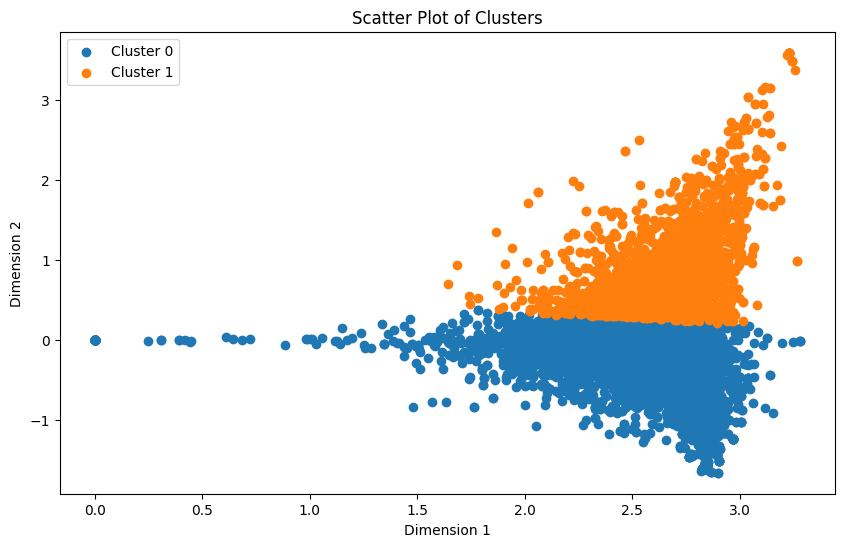

In [ ]:
plt.figure(figsize=(10, 6))
for cluster in range(optimal_num_clusters):
    cluster_data = word2vec_matrix_svd[df['cluster'] == cluster]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {cluster}')
plt.title('Scatter Plot of Clusters')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()

In [ ]:
centroids = kmeans_optimal.cluster_centers_
print("Centroids of Clusters:")
print(centroids)

Centroids of Clusters:
[[ 2.51838009e+00 -3.11393411e-01  2.87260971e-02 -2.95375046e-03
  -9.83349130e-05  2.11626266e-03 -2.53324091e-04  2.54026170e-03
   1.73958913e-04 -3.16419280e-04 -6.68659413e-04  3.03247639e-05
   4.08613256e-04 -2.87176809e-05  4.12725712e-04 -1.12361448e-04
   9.74882591e-05  3.34923101e-04 -8.09143343e-05 -1.67881011e-04
  -1.41944248e-04 -2.59290293e-05 -9.05782077e-05 -5.78531941e-05
  -2.53440538e-05 -3.71391112e-05 -3.80294015e-05  1.30737651e-04
   3.84994302e-05  1.21763115e-05 -5.14415349e-05  5.87179367e-05
   7.20393590e-05 -3.85929647e-06 -4.91088877e-05  5.56904844e-05
  -5.85581660e-05  5.07505652e-05  1.81344791e-05  2.95157707e-05
  -2.09278844e-05  1.74636654e-05 -5.60196966e-05  1.57940550e-05
  -2.49370028e-05 -1.53637452e-05 -5.76380771e-05 -1.70932755e-05
   3.56259584e-05 -4.39629222e-06  2.07493351e-06  1.53490352e-05
  -3.61058100e-05 -1.20719044e-05  4.59833645e-05  4.80260319e-06
  -1.26895216e-05  1.70627373e-05  2.04919176e-05 -3.

In [ ]:
print("Top words or phrases for each cluster:")
for cluster in range(optimal_num_clusters):
    print(f"\nCluster {cluster}:")
    cluster_indices = np.where(cluster_labels_optimal == cluster)[0]
    cluster_text = df.iloc[cluster_indices]['additional_clean']
    cluster_words = ' '.join(cluster_text)
    word_freq = {}
    for word in cluster_words.split():
        word_freq[word] = word_freq.get(word, 0) + 1
    sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
    top_words = [word for word, freq in sorted_word_freq[:10]]
    print(top_words)

Top words or phrases for each cluster:

Cluster 0:
['great', 'fit', 'part', 'good', 'love', 'like', 'quality', 'work', 'shoe', 'nice']

Cluster 1:
['size', 'fit', 'small', 'ordered', 'would', 'part', 'little', 'big', 'great', 'costume']
